<a href="https://colab.research.google.com/github/xidulu/model_misspecification/blob/main/Model_Misspecification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The famous model misspecification example

In [126]:
!pip install numpyro

In [127]:
import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, NUTS, MCMC, Predictive, autoguide
from numpyro import handlers
from numpyro.infer import Predictive

import jax
import jax.numpy as jnp
from jax.random import PRNGKey, split
from jax import lax

import matplotlib.pyplot as plt

numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

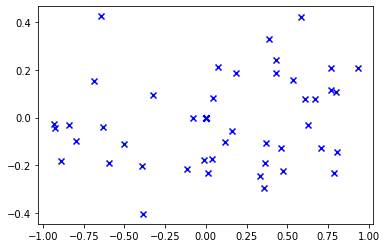

In [139]:
# Create data
np.random.seed(9)
N = 100
mask = (np.random.uniform(size=(N,)) > 0.5) # Simulate a bernoulli-mask
X = mask * np.random.uniform(-1, 1, size=(N,)) + (1 - mask) * 0
y = mask * np.random.normal(scale=np.sqrt(0.05), size=(N,)) + (1 - mask) * 0

plt.scatter(X, y, marker='x', c='b')

X = jnp.power(jnp.array(X[:, None].astype('float32')), jnp.arange(50)) # Polynomial basis function
y = jnp.array(y[:, None].astype('float32'))

In [129]:
def model(X, y=None, T=1.0):
    D_in = X.shape[1]
    D_out = 1
    W = numpyro.sample('W', dist.Normal(jnp.zeros((D_in, D_out)), 1.0 * jnp.ones((D_in, D_out))))
    y_loc = jnp.matmul(X, W)
    y_sigma = numpyro.sample('y_sigma', dist.InverseGamma(1.0, 0.025))
    with handlers.scale(scale=T):
      numpyro.sample("obs", dist.Normal(y_loc, jnp.sqrt(y_sigma)), obs=y)

In [130]:
kernel = NUTS(model)
# kernel = HMC(model)
key = PRNGKey(11)
mcmc = MCMC(kernel, num_samples=2000, num_warmup=2000, num_chains=1)
mcmc.run(key, X, y)

sample: 100%|██████████| 4000/4000 [00:11<00:00, 343.47it/s, 127 steps of size 3.16e-02. acc. prob=0.93]


In [131]:
X_test = jnp.power(jnp.arange(-1, 1, 0.005)[:, None], np.arange(50))
prediction_key = PRNGKey(12)
y_pred = Predictive(model, mcmc.get_samples())(prediction_key, X_test)['obs']
y_pred = np.array(y_pred.squeeze())

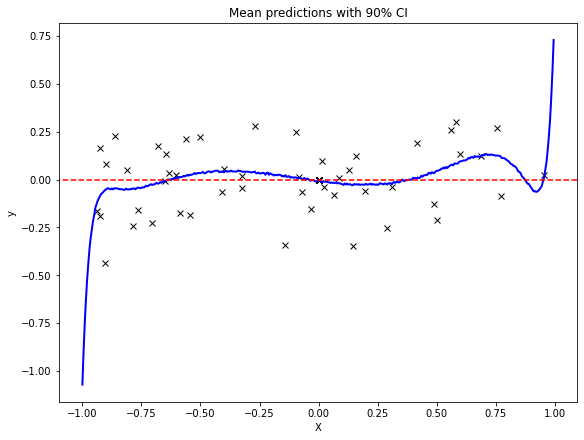

In [132]:
mean_prediction = jnp.mean(y_pred, axis=0)
percentiles = np.percentile(y_pred, [5.0, 95.0], axis=0)

# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X[:, 1], y, "kx")
# plot 90% confidence level of predictions
# ax.fill_between(X_test[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue")

# plot mean prediction
ax.plot(X_test[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="y", title="Mean predictions with 90% CI")
ax.axhline(xmin=-1, xmax=1, color='red',ls='--')

100%|██████████| 50000/50000 [00:52<00:00, 957.51it/s, init loss: 231.8252, avg. loss [47501-50000]: 4.5536] 


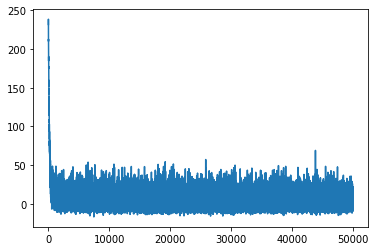

In [137]:
# VI
key_svi = PRNGKey(8)
key_svi, key_ = split(key_svi)
optim = numpyro.optim.Adam(step_size=0.005)
guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=5))
svi_result = svi.run(key_, 50000, X, y)

key_svi, key_ = split(key_svi)
svi_samples = guide.sample_posterior(key_, svi_result.params, (4000,))
key_svi, key_ = split(key_svi)

y_pred = Predictive(model, svi_samples)(key_, X_test)['obs']
y_pred = np.array(y_pred.squeeze())

plt.plot(svi_result.losses)

VI still shows bad result... Need to figure out why...

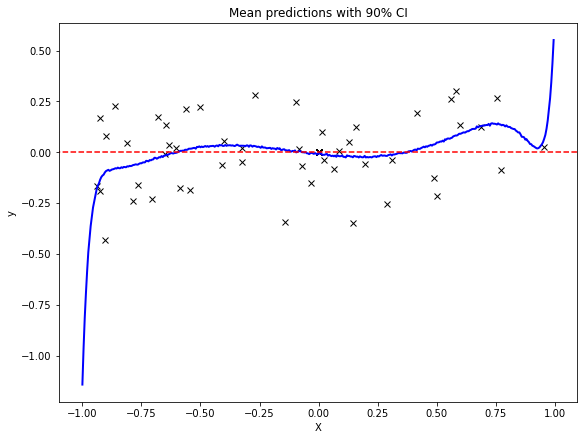

In [138]:
mean_prediction = jnp.mean(y_pred, axis=0)
percentiles = np.percentile(y_pred, [5.0, 95.0], axis=0)

# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X[:, 1], y, "kx")
# plot 90% confidence level of predictions
# ax.fill_between(X_test[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue")

# plot mean prediction
ax.plot(X_test[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="y", title="Mean predictions with 90% CI")
ax.axhline(xmin=-1, xmax=1, color='red',ls='--')